# Background

* In https://arxiv.org/abs/1711.02037, the fast "randomized NMF" algorithm is proposed to solve NMF problem with Frobenius norm. From my previous experiments, it is indeed very fast and still gets good loss. 

* The key is to get a approximation of data $A \in N^{p \times n}$: $A \approx Q^{'} B, Q \in R^{d \times p}, B \in R^{d \times n}$,  , where $Q$ is orthonormal. 

* The theoretical guarantee is that we can bound $E |A - Q^{'} B|$ by the $k+1$th eigenvalue of $A$.

* Then instead of solving 
$$min \ |A - WH|_F \ s.t. \ W \geq 0, H \geq 0$$, 
we solve 
$$min \ |B - \tilde{W}H|_F, \ s.t. \ Q^{'}\tilde{W} \geq 0, H \geq 0$$
We can solve the smaller problem using HALS, and project $\tilde{W}$ back ensure nonnegativity:  
$$W \leftarrow max(0, Q^{'}\tilde{W}) \ ; \ \tilde{W} \leftarrow QW$$.

* However, I have not found similar algorithms for solving NMF with generalized KL divergence. The difficulty lies finding small dimensional "sketching" of $A$ with small error. In fact , it has been shown that this is impossible  for an error bound in https://www.cs.dartmouth.edu/~ac/Teach/CS49-Fall11/Papers/guha-sketchingdivs.pdf (need to read more closely). 

* Although we do not have a theoretical guarantee for solving nmf_kl through random projection, it is still possible that we can get a super fast algorithm that works reasonably well in practice. 

* In my previous experiment, we can see applying NMF_KL on $\hat{A}$ is not too bad when we use a big dimension in computing svd of $A$. 
(https://zihao12.github.io/lowrank-nmf/Experiment_rsvd_betanmf_gtex_d200.html)


# What I have tried

* I start off adjusting code in https://github.com/erichson/ristretto/blob/master/ristretto/nmf.py so that it can work for generalized kl divergence. 

* After I got `QB` factorization, I solve $min \ GKL(B || \tilde{W} H) \ s.t. \ Q^{'}\tilde{W} \geq 0, H \geq 0$ usig multiplicative update. 

* To get `QB` factorization, I tried the following: 

    * Directly using their `QB` factorization scheme does not work, as $B$ has too many negative elements, and $GKL(B, \tilde{W} H)$ only makes sense if $B \geq 0$. 

    * Similarly, using `rsvd` won't work, as $B$ has too many negative elements (some are big)

    * Then I tried `nndsvd` to get approximation of $A$;

    * I also tried `rnmf` (frobenius norm) to get approximation of $A$. 

# Problem
* In my algorithm, I assume the two things but neither of them satisfies:
    * $Q^{'} B$ is a good surrogate of $A$ in nmf_kl
    * $W \approx Q^{'} \tilde{W}$ and we can get $\tilde{W}$ from $QW$
   
* From the results below, we can see `rnmf_kl` with approximation from `rnmf` (with big oversampling) is better, but still lags behind `nmf_kl` 



## Generate data and compute oracle loss

In [1]:
import warnings
warnings.filterwarnings("ignore",category =RuntimeWarning)
import numpy as np
from ristretto import nmf_kl
from sklearn.decomposition import NMF
import time
np.random.seed(123)

## generate data
p = 10000
n = 5000
K = 5
W = np.exp(np.random.uniform(size = (p,K)))
H = np.exp(np.random.uniform(size = (K,n)))
Lam = W.dot(H)
A = np.random.poisson(Lam, size = (p,n))

# compute oracle loss
cost_oracle = nmf_kl.cost(A, W, H)
print("oracle loss: {}".format(cost_oracle))

oracle loss: -1264748462.8393648


## nmf_kl
I implemented multiplicative update in python naively. The same update method is used in `rnmf_kl` as well. 

In [2]:
print("nmf_kl")
start = time.time()
(W_nmfkl,H_nmfkl) = nmf_kl.compute_nmf_kl(A=A,rank = K, maxiter=200)
runtime = time.time() - start
print("runtime: {}".format(runtime))
print("loss: {}".format(nmf_kl.cost(A,W_nmfkl,H_nmfkl)))

nmf_kl
runtime: 250.08735299110413
loss: -1264696227.5196867


## rnmf_kl (approximated with `nndsvd`)

In [3]:
approx = "nndsvd"
print("rnmf_kl: approx with {}".format(approx))
start = time.time()
(W_rnmfkl,H_rnmfkl) = nmf_kl.compute_rnmf_kl(A=A,rank = K, oversample = 100, maxiter = 200, approx=approx)
runtime = time.time() - start
print("runtime: {}".format(runtime))
print("loss: {}".format(nmf_kl.cost(A,W_rnmfkl,H_rnmfkl)))

rnmf_kl: approx with nndsvd
approximation takes 6.680288076400757
runtime: 12.713117361068726
loss: -1255020198.7294621


## rnmf_kl (approximated with `rnmf`)

In [4]:
approx = "rnmf"
print("rnmf_kl: approx with {}".format(approx))
start = time.time()
(W_rnmfkl,H_rnmfkl) = nmf_kl.compute_rnmf_kl(A=A,rank = K, oversample = 100, maxiter = 200, approx=approx)
runtime = time.time() - start
print("runtime: {}".format(runtime))
print("loss: {}".format(nmf_kl.cost(A,W_rnmfkl,H_rnmfkl)))

rnmf_kl: approx with rnmf
approximation takes 59.094603061676025
runtime: 65.46138024330139
loss: -1263914708.9087782


### try a bigger oversampling 

In [5]:
approx = "rnmf"
print("rnmf_kl: approx with {}".format(approx))
start = time.time()
(W_rnmfkl,H_rnmfkl) = nmf_kl.compute_rnmf_kl(A=A,rank = K, oversample = 200, maxiter = 200, approx=approx)
runtime = time.time() - start
print("runtime: {}".format(runtime))
print("loss: {}".format(nmf_kl.cost(A,W_rnmfkl,H_rnmfkl)))

rnmf_kl: approx with rnmf
approximation takes 204.07633900642395
runtime: 212.55510902404785
loss: -1264349618.5342836


# Assess fits

Below I compute p values of fit using $c * ppois(x - 1, lam) + (1 - c) * ppois(x, lam)$. 

In [9]:
import matplotlib.pyplot as plt
from scipy.stats import poisson
# c * ppois(x - 1, lam) + (1 - c) * ppois(x, lam)
def pval(A, W, H, title = ''):
    np.random.seed(123)
    WH = W.dot(H)
    C = np.random.uniform(size = A.shape)
    pvals = C * poisson.pmf(k = A - 1, mu = WH) + (1-C) * poisson.pmf(k = A, mu = WH)
    plt.hist(pvals.flatten())
    plt.xlabel("p value")
    plt.title(title)
    plt.show()

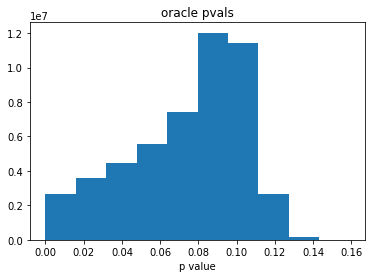

In [10]:
pval(A, W, H, 'oracle pvals')

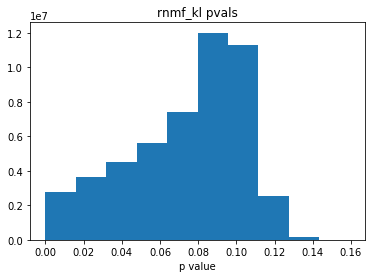

In [11]:
pval(A, W_rnmfkl, H_rnmfkl, 'rnmf_kl pvals')

## Code 
Below are codes I adapted for the computation above

```python
"""
Nonnegative Matrix Factorization With GKL.
"""

from __future__ import division

import numpy as np
from scipy import linalg

from sklearn.decomposition.cdnmf_fast import _update_cdnmf_fast
from sklearn.decomposition.nmf import _initialize_nmf
from sklearn.utils import check_random_state

from .qb import compute_rqb
from .nmf import compute_rnmf

import sys
import time

_VALID_DTYPES = (np.float32, np.float64)



def update_kl(A, W, H,E, eps = 0):
    """ 
    W = W .* (((A ./ (W*H)) * H.') ./ (E * H.'));
    W = max(W,eps);
    H = H .* ((W.' * (A ./ (W*H))) ./ (W.' * E));
    H = max(H,eps);
    """
    mulW = (A/W.dot(H)).dot(H.T)/(E.dot(H.T))
    W *= mulW
    W = W.clip(min = eps)

    mulH = W.T.dot(A/W.dot(H))/(W.T.dot(E))
    H *= mulH
    H = H.clip(min = eps)

    return W, H

def cost(A, W,H, eps = 0):
    """
    sum(sum(WH - A.*log(WH + eps)))
    """
    WH = W.dot(H)
    return (WH - A *np.log(WH + eps)).sum()




def compute_nmf_kl(A, rank, init='nndsvda', eps = sys.float_info.min, shuffle=False,
                l2_reg_H=0.0, l2_reg_W=0.0, l1_reg_H=0.0, l1_reg_W=0.0,
                tol=1e-5, maxiter=200, random_state=None):
   
    random_state = check_random_state(random_state)

    # converts A to array, raise ValueError if A has inf or nan
    A = np.asarray_chkfinite(A)
    m, n = A.shape

    if np.any(A < 0):
        raise ValueError("Input matrix with nonnegative elements is required.")

    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Initialization methods for factor matrices W and H
    # 'normal': nonnegative standard normal random init
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    W, H = _initialize_nmf(A, rank, init=init, eps=1e-6, random_state=random_state)

    E = np.ones(A.shape)
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Iterate the mu algorithm until maxiter is reached
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    for niter in range(maxiter):

        W, H = update_kl(A, W, H,E, eps = eps)
    # Return factor matrices
    return W, H


def compute_rnmf_kl(A, rank, oversample=100, init='nndsvda',eps = sys.float_info.min,
                 tol=1e-5, maxiter=200, random_state=None, approx = 'nndsvd'):
    
    random_state = check_random_state(random_state)

    # converts A to array, raise ValueError if A has inf or nan
    A = np.asarray_chkfinite(A)
    m, n = A.shape

    flipped = False
    if n > m:
        A = A.T
        m, n = A.shape
        flipped = True

    # if A.dtype not in _VALID_DTYPES:
    #     raise ValueError('A.dtype must be one of %s, not %s'
    #                      % (' '.join(_VALID_DTYPES), A.dtype))

    if np.any(A < 0):
        raise ValueError("Input matrix with nonnegative elements is required.")


    
    # compute low rank "projection"
    # I hope to get A \approx Q' * B, where 
    # Q (p,d) is orthonormal, nonnegative
    # B (d,n) is nonnegative

    ## one way: just use nndsvd
    if approx == 'nndsvd':
        start = time.time()
        Q, B = _initialize_nmf(A, rank+oversample, init="nndsvd", eps=1e-6, random_state=random_state)
        print("approximation takes {}".format(time.time() - start))

    ## the other way: use rnmf
    if approx == 'rnmf':
        start = time.time()
        Q, B = compute_rnmf(A, rank+oversample, init = "nndsvd")
        print("approximation takes {}".format(time.time() - start))

    #  Initialization methods for factor matrices W and H
    W, H = _initialize_nmf(A, rank, init=init, eps=1e-6, random_state=random_state)
    Ht = np.array(H.T, order='C')
    W_tilde = Q.T.dot(W)
    del A

    E = np.ones(B.shape)

    #  Iterate the mu algorithm until maxiter is reached
    for niter in range(maxiter):

        W_tilde, H = update_kl(B, W_tilde, H,E, eps = eps)

        W = Q.dot(W_tilde)
        W = W.clip(min = eps)
        W_tilde = Q.T.dot(W)

    # Return factor matrices
    if flipped:
        return(Ht, W.T)
    return W, H


```